# Point-symmetric fiber lens optimization

Fiber lenses, or microlenses fabricated directly on optical fiber tips, are essential components for beam shaping, focusing, and coupling in fiber-optic systems. Applications range from optical trapping and sensing to endoscopy and telecommunications.

In this notebook, we design a fiber lens by optimizing the 3D surface profile of a cylindrically symmetric structure attached to the tip of a single-mode fiber. The lens surface is parameterized as **concentric rings** whose heights are adjusted via gradient-based inverse design using Tidy3D's native [autograd](https://docs.flexcompute.com/projects/tidy3d/en/latest/notebooks/docs/features/autograd.html) support. The objective is to maximize the optical flux transmitted to a small focal region in front of the fiber.

We demonstrate **free-form 3D shape optimization** using a fully differentiable `TriangleMesh` geometry. Unlike topology optimization on a fixed pixel grid, this approach directly optimizes vertex positions of a surface mesh, enabling smooth, fabrication-ready freeform surfaces that can be exported directly to STL. This capability is particularly powerful for freeform optics where the optimal shape cannot be described by simple geometric primitives.

<img src="./img/fiber_lens.png" style="width:30%;">
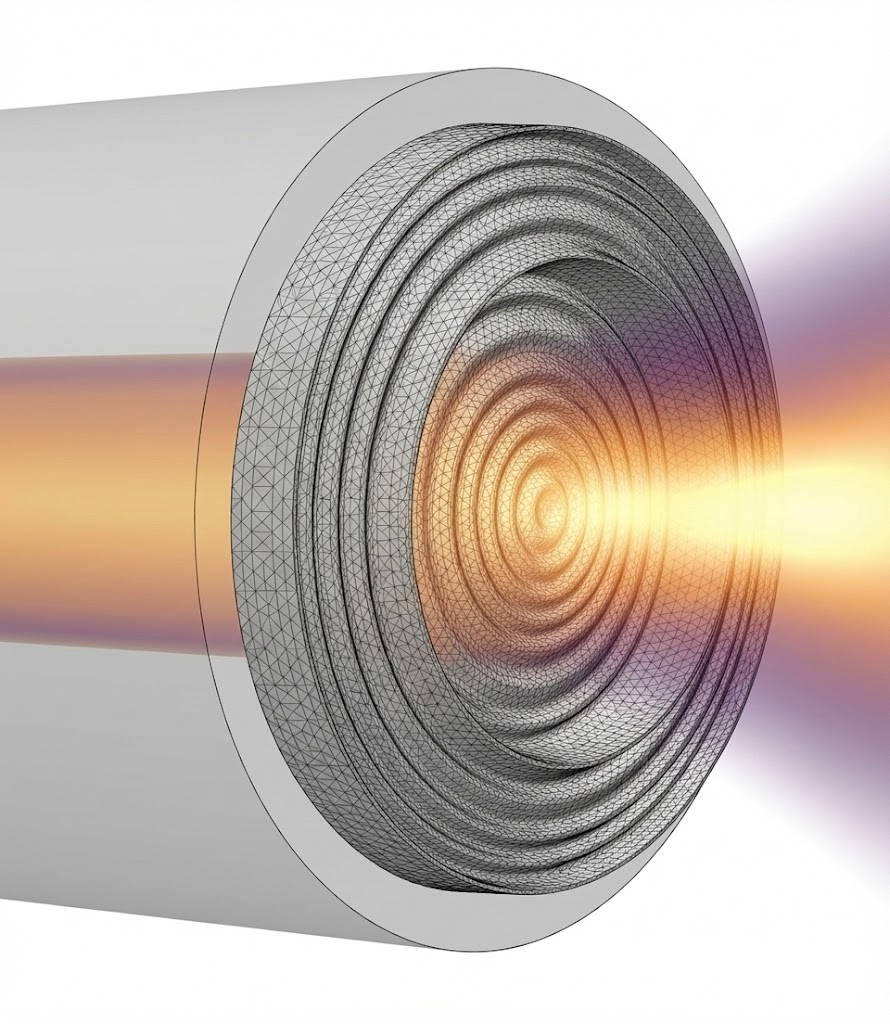

## Initial Setup

We begin by importing the necessary packages and defining the key parameters for our simulation. The physical setup consists of:

1. **Fiber base**: A single-mode fiber with core and cladding
2. **Lens structure**: A cylinder-like design region whose top surface will be optimized
3. **Exit monitor**: A small field monitor at the target focal plane to measure focusing efficiency

The lens surface is discretized into `num_rings` concentric rings, each with an adjustable height. A Gaussian smoothing kernel is applied to ensure smooth, fabricable transitions between adjacent rings.

In [1]:
import autograd.numpy as anp
import matplotlib.pyplot as plt
import numpy as np
import optax
import tidy3d as td
import tidy3d.web as web
from autograd import value_and_grad
from autograd.scipy.signal import convolve
from tidy3d.components.autograd import get_static

td.config.logging.level = "ERROR"  # disable warning about large number of source grid points
# Operating wavelength and frequency (units: µm)
wvl = 1.55
freq0 = td.C_0 / wvl

# Fiber geometry and refractive indices (approximate SMF-28 values)
d_smf_core = 8.2  # core diameter (µm)
n_smf_core = 1.449217  # core refractive index
n_smf_clad = 1.444  # cladding refractive index
n_design = 2.0  # refractive index of lens material (e.g., polymer or glass)
base_design_radius = 10  # radius of the lens base (µm)
fiber_length = 2  # length of fiber section in simulation (µm)

# Longitudinal layout (µm)
initial_height = 2.0  # starting height for all rings
free_space_length = 20.0  # propagation distance to focal plane
pml_buffer = wvl * 1.5  # buffer between structures and PML
monitor_buffer = 0.5  # buffer for source/monitor placement

# Simulation domain extent (µm)
sim_Ly = sim_Lz = 2 * base_design_radius + pml_buffer
sim_Lx = fiber_length + free_space_length
exit_monitor_size = 0.5  # size of the focal spot monitor

# Mesh parameterization
num_rings = 128  # number of concentric rings (design parameters)
ring_segments = 128  # polygon edges per ring (angular resolution)
smooth_sigma_frac = 0.02  # smoothing kernel width = num_rings * smooth_sigma_frac

# Height bounds for optimization (µm)
min_height, max_height = 0.1, 10.0

## Simulation Setup

We now construct the base simulation containing the optical fiber without the lens structure. The fiber consists of a cylindrical core (higher refractive index) surrounded by cladding (lower refractive index). Both extend beyond the simulation boundaries to avoid edge effects at the PML.

In [5]:
INF = 1000
clad = td.Structure(
    geometry=td.Box.from_bounds((-INF, -INF, -INF), (fiber_length, INF, INF)),
    medium=td.Medium(permittivity=n_smf_clad**2),
)

core = td.Structure(
    geometry=td.Cylinder(
        center=clad.geometry.center,
        radius=d_smf_core / 2,
        length=clad.geometry.size[0],
        axis=0,
    ),
    medium=td.Medium(permittivity=n_smf_core**2),
)

We excite the fundamental mode of the fiber using a [ModeSource](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.ModeSource.html). The mode solver automatically finds the guided mode, and we filter for TE polarization. The source emits a Gaussian pulse centered at the operating wavelength.

In [6]:
mode_source = td.ModeSource(
    size=(0, sim_Ly, sim_Lz),
    center=(monitor_buffer, 0, 0),
    source_time=td.GaussianPulse(freq0=freq0, fwidth=0.2 * freq0),
    mode_spec=td.ModeSpec(
        num_modes=1,
        target_neff=n_smf_core,
        sort_spec=td.ModeSortSpec(filter_key="TE_fraction", filter_reference=0.5),
        num_pml=(12, 12),
    ),
    direction="+",
    name="fiber_input",
)

A [FieldMonitor](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.FieldMonitor.html) is placed at the target focal plane to capture the electric and magnetic fields. The monitor size defines the "focal spot" region where we want to concentrate light.

In [7]:
exit_monitor = td.FieldMonitor(
    center=(sim_Lx - monitor_buffer, 0, 0),
    size=(0, exit_monitor_size, exit_monitor_size),
    freqs=[freq0],
    name="field_exit",
)

We now assemble the base simulation with the fiber structures, source, and monitors. Optionally, a field monitor at z=0 can be added to visualize the field propagation along the optical axis.

In [8]:
def make_base_simulation(monitor_propagation=False):
    """Create the parameter-independent base simulation."""
    monitors = [exit_monitor]
    if monitor_propagation:
        monitors.append(
            td.FieldMonitor(
                center=(0, 0, 0), size=(td.inf, td.inf, 0), freqs=[freq0], name="field_z_0"
            )
        )

    propagation_distance = initial_height + free_space_length
    run_time = 10 * propagation_distance / td.C_0
    sim = td.Simulation(
        size=(sim_Lx, sim_Ly, sim_Lz),
        center=(sim_Lx / 2, 0, 0),
        grid_spec=td.GridSpec.auto(min_steps_per_wvl=20, wavelength=wvl),
        structures=[clad, core],
        sources=[mode_source],
        monitors=monitors,
        run_time=run_time,
    )

    return sim


base_sim = make_base_simulation()

Let's visualize the base simulation in 2D cross-sections and 3D to verify the geometry and component placement.

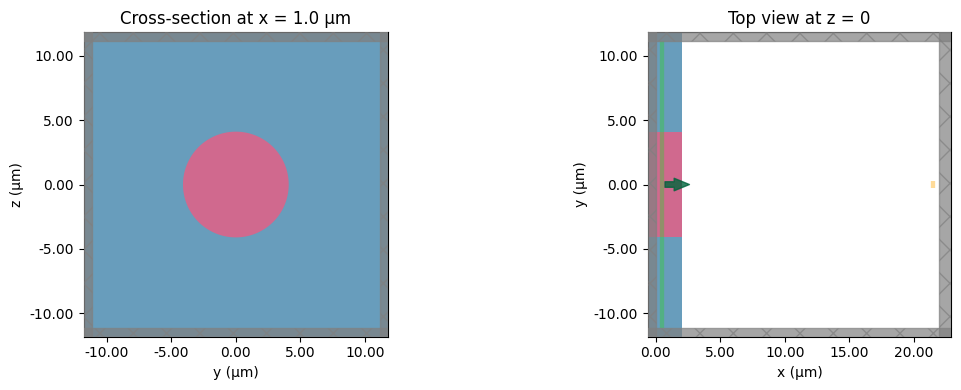

In [6]:
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(12, 4))
base_sim.plot(x=fiber_length / 2, ax=ax1)
ax1.set_title(f"Cross-section at x = {fiber_length / 2} µm")
base_sim.plot(z=0, ax=ax2)
ax2.set_title("Top view at z = 0")
plt.show()

base_sim.plot_3d()

## Mesh Construction

The lens geometry is defined as a [TriangleMesh](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.TriangleMesh.html) constructed from vertices and faces. The surface is parameterized as follows:

- **Base ring**: A circle at the fiber tip (height = 0) forming the lens base
- **Concentric top rings**: Each ring has an adjustable height controlled by the optimization parameters
- **Center vertices**: Top and bottom center points to close the mesh

The height profile is smoothed using a Gaussian kernel to ensure gradual transitions between adjacent rings, which improves manufacturability and avoids sharp discontinuities that could cause meshing issues.

In [9]:
def vertices_from_params(params):
    def smooth_param_profile(params):
        sigma = smooth_sigma_frac * len(params)
        if sigma == 0:
            return params
        pad = max(1, int(4 * sigma))

        # gaussian kernel
        x = anp.arange(-pad, pad + 1)
        k = anp.exp(-0.5 * (x / sigma) ** 2)
        k /= k.sum()

        # padding
        left_pad = params[1 : pad + 1][::-1]
        right_pad = params[-pad - 1 : -1][::-1]
        padded = anp.concatenate([left_pad, params, right_pad])

        # convolve
        smoothed = convolve(padded, k, mode="valid")
        return smoothed

    heights = smooth_param_profile(params)
    theta = anp.linspace(0.0, 2.0 * anp.pi, ring_segments, endpoint=False)
    cos_t = anp.cos(theta)
    sin_t = anp.sin(theta)

    rings = []

    # bottom base ring at height = 0
    X = anp.full(ring_segments, fiber_length)
    Y = base_design_radius * cos_t
    Z = base_design_radius * sin_t
    rings.append(anp.stack([X, Y, Z], axis=1))

    # rings for radius > 0
    ring_radii = np.linspace(0.0, base_design_radius, num_rings)
    for radius, h in zip(ring_radii[1:], heights[1:]):
        X = anp.full(ring_segments, fiber_length + h)
        Y = radius * cos_t
        Z = radius * sin_t
        rings.append(anp.stack([X, Y, Z], axis=1))

    vertices = anp.concatenate(rings, axis=0)

    # bottom and top center vertex
    top_center = anp.array([[fiber_length + heights[0], 0.0, 0.0]])
    bottom_center = anp.array([[fiber_length + 0.0, 0.0, 0.0]])

    vertices = anp.concatenate([vertices, top_center, bottom_center], axis=0)
    return vertices

Next, we define the triangular faces that connect the vertices. The vertex ordering must be **counter-clockwise** when viewed from outside the mesh to ensure correct surface normals.

In [10]:
def build_faces(num_rings):
    faces: list[list[int]] = []

    def ring_offset(i: int) -> int:
        return i * ring_segments

    K = num_rings - 1  # index of the outermost top ring

    top_center_idx = num_rings * ring_segments
    bottom_center_idx = top_center_idx + 1

    # ---- side wall between base ring and outermost top ring ----
    base = ring_offset(0)
    outer = ring_offset(K)
    for j in range(ring_segments):
        jn = (j + 1) % ring_segments
        faces.append([base + j, base + jn, outer + j])
        faces.append([base + jn, outer + jn, outer + j])

    # center fan on top surface: top_center ↔ ring 1
    inner_ring = ring_offset(1)
    for j in range(ring_segments):
        jn = (j + 1) % ring_segments
        faces.append([top_center_idx, inner_ring + j, inner_ring + jn])

    # ring-by-ring faces between top rings:
    # connect 1↔2, 2↔3, ..., (K-1)↔K
    for i in range(1, K):
        r0 = ring_offset(i)
        r1 = ring_offset(i + 1)
        for j in range(ring_segments):
            jn = (j + 1) % ring_segments
            faces.append([r0 + j, r1 + j, r0 + jn])
            faces.append([r0 + jn, r1 + j, r1 + jn])

    # ---- bottom disk: fan from bottom_center to base ring ----
    base_start = ring_offset(0)
    for j in range(ring_segments):
        jn = (j + 1) % ring_segments
        faces.append([bottom_center_idx, base_start + jn, base_start + j])
    faces = anp.array(faces, dtype=int)
    return faces

We can now construct the complete mesh from a parameter vector. The `mesh_from_params` function computes vertices from the parameters and combines them with the precomputed face connectivity to create a `TriangleMesh` object.

In [11]:
FACE_ARRAY = build_faces(num_rings)


def mesh_from_params(params):
    vertices = vertices_from_params(params)
    triangles = vertices[FACE_ARRAY]
    mesh = td.TriangleMesh.from_triangles(triangles)
    return mesh

## Mesh Visualization

Before optimization, let's verify the mesh construction by creating a lens with randomized ring heights. This helps confirm that the geometry, smoothing, and triangulation work correctly.

<Axes: title={'center': 'cross section at z=0.00 (μm)'}, xlabel='x (μm)', ylabel='y (μm)'>

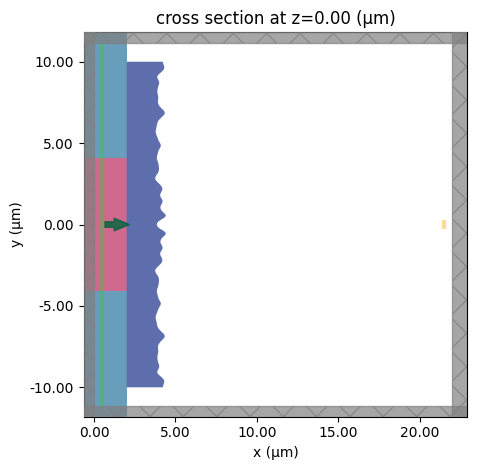

In [16]:
def get_fiber_design_sim(params, monitor_propagation=False):
    """Create simulation with fiber and parameterized lens structure."""
    mesh = mesh_from_params(params)
    base_sim = make_base_simulation(monitor_propagation=monitor_propagation)
    medium = td.Medium(permittivity=n_design**2)
    design_structure = td.Structure(geometry=mesh, medium=medium, name="lens")
    new_structures = [*base_sim.structures, design_structure]
    return base_sim.updated_copy(structures=new_structures, validate=True)


# Create example with random perturbations
example_params = np.full(num_rings, initial_height) + np.random.randn(num_rings) * 0.5
example_design_sim = get_fiber_design_sim(example_params)
example_design_sim.plot_3d()  #  3D plot
example_design_sim.plot(z=0)  #  2D plot

## Objective Function

The objective function defines what we want to optimize. Here, we maximize the optical power (flux) transmitted through the exit monitor at the focal plane. The function:

1. Constructs a simulation from the current parameters
2. Runs the FDTD simulation via `web.run()`
3. Extracts and returns the flux from the field monitor

In [11]:
def objective(params):
    """Compute the flux at the focal plane for a given set of ring heights."""
    sim = get_fiber_design_sim(params)
    sim_data = web.run(sim, task_name="fiber_lens_opt", verbose=False)
    flux = sim_data["field_exit"].flux.values
    return flux

## Optimization

We use [optax](https://optax.readthedocs.io/) with the Adam optimizer to iteratively improve the lens design. At each step:

1. Compute the objective value and gradient using `value_and_grad`
2. Update parameters using Adam
3. Clip parameters to stay within physical bounds

The gradient is computed efficiently via the adjoint method: only two simulations (forward + adjoint) are needed per step, regardless of the 128 design parameters.

In [12]:
# Optimization configuration
num_steps = 30
learning_rate = 0.1

# Initialize parameters (uniform height) and optimizer
params = anp.full(num_rings, initial_height, dtype=float)
optimizer = optax.adam(learning_rate=learning_rate)
opt_state = optimizer.init(params)
val_and_grad = value_and_grad(objective)

# Optimization loop
history = []
for step in range(1, num_steps + 1):
    value, grad = val_and_grad(params)
    history.append(float(value.item()))
    grad_norm = float(np.linalg.norm(grad))
    print(f"Step {step:02d}/{num_steps}: flux = {value.item():.4e}, ||∇|| = {grad_norm:.4e}")

    # Update parameters (maximize by negating gradient)
    updates, opt_state = optimizer.update(-grad, opt_state, params)
    params = optax.apply_updates(params, updates)
    params = anp.clip(params, min_height, max_height)

Step 01/30: flux = 5.6026e-03, ||∇|| = 8.6030e-03
Step 02/30: flux = 1.3560e-02, ||∇|| = 9.4723e-03
Step 03/30: flux = 1.9681e-02, ||∇|| = 7.9627e-03
Step 04/30: flux = 2.4583e-02, ||∇|| = 8.1960e-03
Step 05/30: flux = 2.7092e-02, ||∇|| = 1.0414e-02
Step 06/30: flux = 2.8598e-02, ||∇|| = 1.0662e-02
Step 07/30: flux = 3.0051e-02, ||∇|| = 9.9789e-03
Step 08/30: flux = 3.1268e-02, ||∇|| = 9.3117e-03
Step 09/30: flux = 3.1827e-02, ||∇|| = 9.7807e-03
Step 10/30: flux = 3.2152e-02, ||∇|| = 1.0412e-02
Step 11/30: flux = 3.2826e-02, ||∇|| = 9.1949e-03
Step 12/30: flux = 3.3350e-02, ||∇|| = 7.6230e-03
Step 13/30: flux = 3.3799e-02, ||∇|| = 8.1709e-03
Step 14/30: flux = 3.4668e-02, ||∇|| = 7.4223e-03
Step 15/30: flux = 3.5575e-02, ||∇|| = 6.2110e-03
Step 16/30: flux = 3.6098e-02, ||∇|| = 5.7248e-03
Step 17/30: flux = 3.6513e-02, ||∇|| = 5.0135e-03
Step 18/30: flux = 3.6688e-02, ||∇|| = 4.8511e-03
Step 19/30: flux = 3.6800e-02, ||∇|| = 5.5917e-03
Step 20/30: flux = 3.7094e-02, ||∇|| = 6.0787e-03


## Results Analysis

Let's analyze the optimization results by plotting the convergence history and visualizing the optimized lens alongside the field distribution. The optimized design typically exhibits a wave-like (Fresnel-like) surface profile that focuses light to the target region.

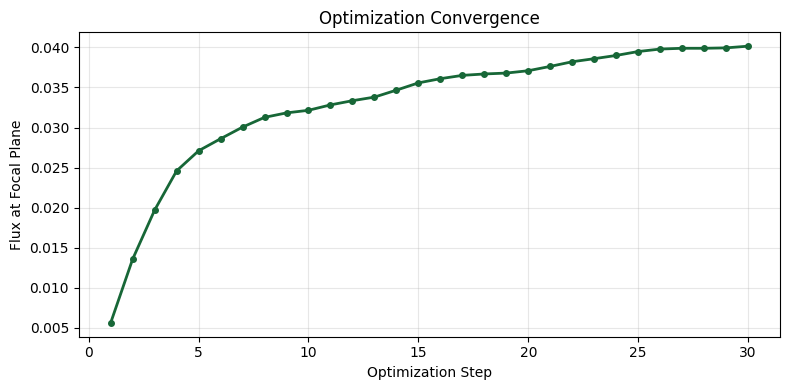


Final flux at focal plane: 4.0488e-02


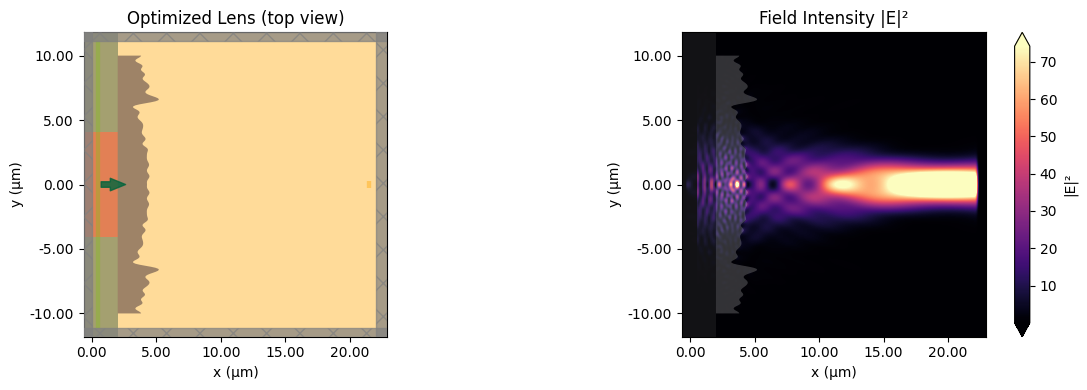

In [15]:
def plot_history(history):
    """Plot the optimization convergence history."""
    plt.figure(figsize=(8, 4))
    plt.plot(np.arange(1, len(history) + 1), history, "o-", linewidth=2, markersize=4)
    plt.xlabel("Optimization Step")
    plt.ylabel("Flux at Focal Plane")
    plt.title("Optimization Convergence")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_design_and_field(sim, data):
    """Plot the lens geometry and field distribution side by side."""
    f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(12, 4))
    sim.plot(z=0, ax=ax1)
    ax1.set_title("Optimized Lens (top view)")
    data.plot_field("field_z_0", "E", "abs^2", ax=ax2)
    ax2.set_title("Field Intensity |E|²")
    plt.show()


# Plot convergence
plot_history(history)

# Run final simulation with propagation monitor
final_sim = get_fiber_design_sim(params, monitor_propagation=True)
final_data = web.run(
    final_sim, task_name="fiber_lens_final", verbose=False, path="fiber_lens_final.hdf5"
)

# Report final performance
final_flux = final_data["field_exit"].flux.values
print(f"\nFinal flux at focal plane: {final_flux.item():.4e}")

# Visualize results
plot_design_and_field(final_sim, final_data)
final_sim.plot_3d()

## Export Results

Finally, we save the optimized parameters and export the lens geometry as an STL file for fabrication or further analysis in CAD software.

In [14]:
# Save optimized parameters
np.save("fiber_lens_params.npy", get_static(params))
print(f"Saved {num_rings} optimized ring heights to 'fiber_lens_params.npy'")

# Export mesh as STL
mesh = mesh_from_params(params)
mesh.to_stl("fiber_lens.stl")
print("Exported lens geometry to 'fiber_lens.stl'")

Saved 128 optimized ring heights to 'fiber_lens_params.npy'
Exported lens geometry to 'fiber_lens.stl'


## Summary

In this notebook, we demonstrated inverse design of a fiber lens using Tidy3D's native autograd support. Key takeaways:

- **TriangleMesh parameterization**: Complex 3D surfaces can be optimized by making vertex positions differentiable
- **Gaussian smoothing**: Applying a smoothing kernel to parameters ensures manufacturable designs
- **Adjoint efficiency**: Gradients for 128 parameters are computed with just 2 simulations per step
- **STL export**: Optimized geometries can be directly exported for fabrication

### Related Examples

- [Inverse Design Overview](https://www.flexcompute.com/tidy3d/examples/notebooks/Autograd0Overview/): Introduction to autograd in Tidy3D
- [Metalens Optimization](https://www.flexcompute.com/tidy3d/examples/notebooks/Autograd7Metalens/): Optimizing a flat metalens for focusing
- [Grating Coupler](https://www.flexcompute.com/tidy3d/examples/notebooks/Autograd6GratingCoupler/): Inverse design of fiber-to-chip coupling
- [Boundary Gradients](https://www.flexcompute.com/tidy3d/examples/notebooks/Autograd5BoundaryGradients/): Shape optimization fundamentals
